# Building A Book Recommendation System

In this project we will implement a [recommendation system](https://en.wikipedia.org/wiki/Recommender_system) for books. We will first read in and explore our datasets a bit, then we will try to build a basic recommender. Afterwards we'll try and improve upon it by implementing a collaborative-filtering engine. Our data will come from [Goodreads](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home). The data was scraped by the team at UCSD in 2017, though some of the files were updated in May 2019.

**What is Goodreads?**

> Goodreads is the world's largest site for readers and book recommendations. Our mission is to help people find and share books they love. If you're looking for a place to discover a great book or to discuss your favorite books with a community of readers, you've found the right place! While we don't have a site tutorial, you can visit the [About us](https://www.goodreads.com/about/us) page to learn more!

**What Can You Do On Goodreads?**

>* See what books your friends are reading.
>* Track the books you're reading, have read, and want to read.
>* Check out your personalized book recommendations. Our recommendation engine analyzes 20 billion data points to give suggestions tailored to your literary tastes.
>* Find out if a book is a good fit for you from our community’s reviews.

## Project Goals

* Become familiar with recommender systems
* Parse .json data for data we're interested in
* Build basic recommendation system
* Improve recommendation system with collaborative filtering
* Display results in an aesthetically pleasing manner

# Import Libraries & Tools

In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix

## Reading In Data

We are dealing with a couple of `.json.gz` files, which can be rather large (> 10 GB). Instead of reading in the entire file into a pandas dataframe, performing operations on it, copying it, modifying it, etc., we will stream through it one line at a time. This is way less computationally taxing on our system in terms of necessary RAM.

In [2]:
# read a single line from the .json file
with gzip.open('goodreads_books.json.gz', 'r') as f:
    line = f.readline()

#example of information in our .json.gz file
json.loads(line)

{'isbn': '0312853122',
 'text_reviews_count': '1',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '3', 'name': 'to-read'},
  {'count': '1', 'name': 'p'},
  {'count': '1', 'name': 'collection'},
  {'count': '1', 'name': 'w-c-fields'},
  {'count': '1', 'name': 'biography'}],
 'asin': '',
 'is_ebook': 'false',
 'average_rating': '4.00',
 'kindle_asin': '',
 'similar_books': [],
 'description': '',
 'format': 'Paperback',
 'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'authors': [{'author_id': '604031', 'role': ''}],
 'publisher': "St. Martin's Press",
 'num_pages': '256',
 'publication_day': '1',
 'isbn13': '9780312853129',
 'publication_month': '9',
 'edition_information': '',
 'publication_year': '1984',
 'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
 'book_id': '5333265',
 'ratings_count': '3',
 'work_id': '5400751',
 'title': '

Notice that the `authors` field only lists an `id` and a `role`. We'll have to read in a separate file containing the author information, and later merge it with our working dataset. For now, let's focus on reading in the columns that we are interested in:

* `book_id` - a unique identifier for each book listed on goodreads.com
* `title_without_series` - the simplified title of the book (excludes # in series)
* `authors` - information relating to the person/s who wrote the book
* `ratings_count` - how many times the book has been rated
* `average_rating` - average rating given by users
* `url` - link to the book's page on the goodreads website
* `image_url` - link to the book's cover art

We will start with a simple function to read in a single line of the .json file, and extract the above mentioned data.

In [3]:
#function to grab columns of interest to us
def parse_fields(line):
    data = json.loads(line)
    return {
        'book_id': data['book_id'],
        'title': data['title_without_series'],
        'author': [i['author_id'] for i in data['authors'] if 'author_id' in i],
        'ratings': data['ratings_count'],
        'avg. rating': data['average_rating'],
        'url': data['url'],
        'cover_image': data['image_url']        
    }

#streams every line of .json file and appends to list if the book has > 15 ratings
#takes ~2 minutes
books_titles = []
with gzip.open("goodreads_books.json.gz") as f:
    while True:
        line = f.readline()
        if not line:
            break
            
        fields = parse_fields(line)
        
        try:
            ratings = int(fields["ratings"]) #convert to int type
        except ValueError:
            continue
            
        if ratings > 15: #can play with this number
            books_titles.append(fields)

If we look at our `books_titles` list, we can see an example of what our data looks like:

In [4]:
books_titles[0]

{'book_id': '7327624',
 'title': 'The Unschooled Wizard (Sun Wolf and Starhawk, #1-2)',
 'author': ['10333'],
 'ratings': '140',
 'avg. rating': '4.03',
 'url': 'https://www.goodreads.com/book/show/7327624-the-unschooled-wizard',
 'cover_image': 'https://images.gr-assets.com/books/1304100136m/7327624.jpg'}

We can see that we have the basic information for a single book. Let's clean up some of the strings in the titles so that we make things easier for us down the road. Specifically, we'll remove characters from the `title` that are **not** letters, numbers, or whitespaces. This will help us when we create a TF-IDF matrix later on, as it will result in less calculations.

In [5]:
#minor data cleaning
titles = pd.DataFrame.from_dict(books_titles)
titles['ratings'] = pd.to_numeric(titles['ratings'])

#remove certain characters and whitespaces
titles['mod_title'] = (
    titles['title'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)
    .str.lower()
    .str.replace('\s+', ' ', regex=True)
)

#removes any entries whose mod_titles are blank
titles = titles[titles['mod_title'].str.len() > 0]
titles.head()

,book_id,title,author,ratings,avg. rating,url,cover_image,mod_title
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[10333],140,4.03,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,the unschooled wizard sun wolf and starhawk 12
1,6066819,Best Friends Forever,[9212],51184,3.49,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,best friends forever
2,287141,The Aeneid for Boys and Girls,[3041852],46,4.13,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,the aeneid for boys and girls
3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,[19158],98,4.22,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,alls fairy in love and war avalon web of magic 8
4,287149,The Devil's Notebook,"[2983296, 40075]",986,3.81,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,the devils notebook


# Import Author Information

We'll have to import the relevant author information from a separate `.json` file. Some books have multiple authors listed. After some experimentation and digging, it seems that goodreads has included *everyone* who contributed to the book as an author - this means if someone illustrated something, translated something, or wrote the foreword for the book, they were counted as an author. It does appear that this information is supplied via the `role` key in dictionary for `authors` in our `goodreads_books.json` file (though it isn't always provided). It seems the main author is typically listed first, so we'll be using that information to display the main author.

In [6]:
#function to grab author info
def parse_authors(line):
    data = json.loads(line)
    return {
        'author_id': data['author_id'],
        'name': data['name']
    }
    
#streams every line of file and appends author info to list
author_dict = {}
with gzip.open("goodreads_book_authors.json.gz") as f:
    while True:
        line = f.readline()
        if not line:
            break
            
        author_info = parse_authors(line)
        author_dict[author_info['author_id']] = author_info['name']

#function that maps author_id with actual name
def replace_authors(authors):
    if len(authors) == 1: #only one author listed
        return author_dict[authors[0]]
    else: #multiple authors listed
        new_authors = []
        for author in authors:
            new_authors.append(author_dict[author])
        all_auth = ', '.join(new_authors) #returning new_authors[0] gives error?
        return all_auth.split(',')[0]
    
#corrects author column
titles['author'] = titles['author'].apply(replace_authors)
titles['author'] = titles['author'].str.replace('\s+', ' ', regex=True)

#ensure avg. ratings are floats
titles['avg. rating'] = titles['avg. rating'].astype(float)

#save to .json so we can use later
titles.to_json('books_titles.json')
titles.head()

,book_id,title,author,ratings,avg. rating,url,cover_image,mod_title
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Barbara Hambly,140,4.03,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,the unschooled wizard sun wolf and starhawk 12
1,6066819,Best Friends Forever,Jennifer Weiner,51184,3.49,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,best friends forever
2,287141,The Aeneid for Boys and Girls,Alfred J. Church,46,4.13,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,the aeneid for boys and girls
3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,Rachel Roberts,98,4.22,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,alls fairy in love and war avalon web of magic 8
4,287149,The Devil's Notebook,Anton Szandor LaVey,986,3.81,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,the devils notebook


In [7]:
len(books_titles)

1308957

In [8]:
titles['avg. rating'].describe()

count    1.302659e+06
mean     3.886204e+00
std      3.606750e-01
min      0.000000e+00
25%      3.670000e+00
50%      3.910000e+00
75%      4.130000e+00
max      5.000000e+00
Name: avg. rating, dtype: float64

In [9]:
titles[titles['avg. rating'] >= 0.00]

,book_id,title,author,ratings,avg. rating,url,cover_image,mod_title
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Barbara Hambly,140,4.03,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,the unschooled wizard sun wolf and starhawk 12
1,6066819,Best Friends Forever,Jennifer Weiner,51184,3.49,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,best friends forever
2,287141,The Aeneid for Boys and Girls,Alfred J. Church,46,4.13,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,the aeneid for boys and girls
3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,Rachel Roberts,98,4.22,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,alls fairy in love and war avalon web of magic 8
4,287149,The Devil's Notebook,Anton Szandor LaVey,986,3.81,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,the devils notebook
...,...,...,...,...,...,...,...,...
1308952,17805813,"Ondine (Ondine Quartet, #0.5)",Emma Raveling,327,4.02,https://www.goodreads.com/book/show/17805813-o...,https://images.gr-assets.com/books/1379766592m...,ondine ondine quartet 05
1308953,331839,Jacqueline Kennedy Onassis: Friend of the Arts,Beatrice Gormley,18,4.36,https://www.goodreads.com/book/show/331839.Jac...,https://s.gr-assets.com/assets/nophoto/book/11...,jacqueline kennedy onassis friend of the arts
1308954,2685097,The Spaniard's Blackmailed Bride,Trish Morey,112,3.42,https://www.goodreads.com/book/show/2685097-th...,https://s.gr-assets.com/assets/nophoto/book/11...,the spaniards blackmailed bride
1308955,2342551,The Children's Classic Poetry Collection,Nicola Baxter,36,4.00,https://www.goodreads.com/book/show/2342551.Th...,https://s.gr-assets.com/assets/nophoto/book/11...,the childrens classic poetry collection


In [10]:
def plot_dist(df, col, title, sub, bins=100, kde=True):
    fig = plt.figure(figsize=(15,8))
    ax = sns.histplot(data=df, x=col, bins=bins, kde=kde)
    
    #lines, labels, and limits
    # ax.set_xlim(-0.1,5.3)
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(labelsize=18)
    ax.axhline(y=0, color='black', linewidth=8, alpha=.7)
        
    #title & subtitle
    ax.text(-0.07,1.09, s=title, fontsize=28, weight='bold', alpha=.75, transform=ax.transAxes)
    ax.text(-0.07,1.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)
    
    #signature bar
    ax.text(x=-0.07, y=-0.08,
            s=' ©NoahGampe' + ' '*160 + 'Source: UCSD Book Graph ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=ax.transAxes)
    
    plt.show()

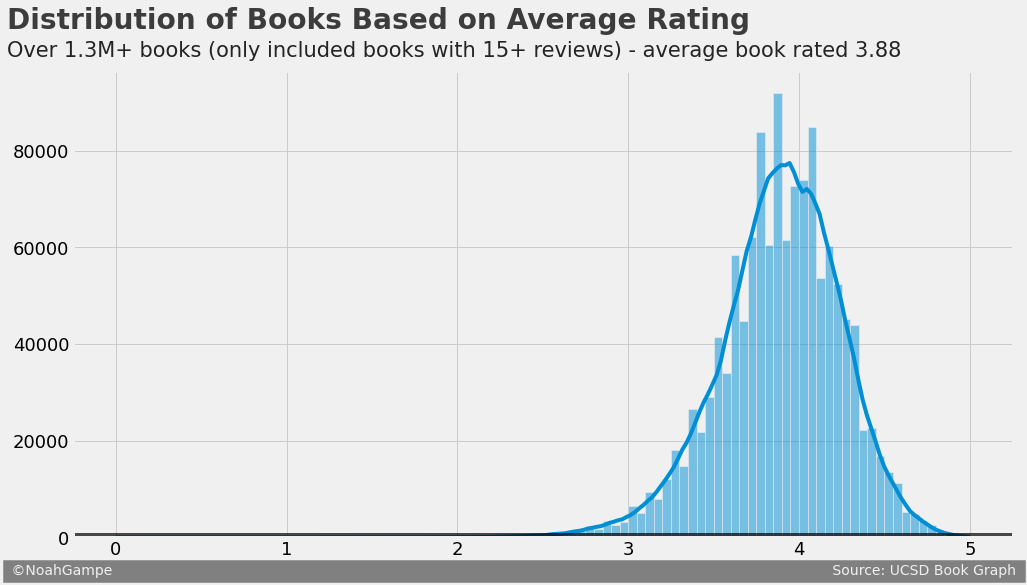

In [11]:
title = 'Distribution of Books Based on Average Rating'
sub = 'Over 1.3M+ books (only included books with 15+ reviews) - average book rated 3.88'
plot_dist(titles, 'avg. rating', title, sub)

In [12]:
#function to assign label given an hour
def assign_label(ratings):
    if 0 <= ratings < 30:
        return 0 
    elif 30 <= ratings < 50:
        return 1 
    elif 50 <= ratings < 100:
        return 2 
    elif 100 <= ratings < 200:
        return 3 
    elif 200 <= ratings < 500:
        return 4 
    elif 500 <= ratings < 1000:
        return 5
    elif 1000 <= ratings < 5000:
        return 6 
    elif 5000 <= ratings < 10000:
        return 7 
    elif 10000 <= ratings < 50000:
        return 8 
    elif 50000 <= ratings < 100000:
        return 9 
    elif 100000 <= ratings < 1000000:
        return 10 
    elif 1000000 <= ratings: 
        return 11
    else:
        return -1 #error
    
def plot_dist_2(df, col, title, sub, bins=100):
    fig = plt.figure(figsize=(15,8))
    ax = sns.histplot(data=df, x=col, bins=bins, hue=col, discrete=True, alpha=1, legend=False)
    
    #lines, labels, and limits
    xtick = ['0-30', '30-50', '50-100', '100-200', '200-500', '500-1K', '1K-5K',
              '5K-10K', '10K-50K', '50K-100K', '100K-1M', '1M+']
    
    ax.set_xlim(-0.5,11.5,1)
    ax.set_xticks(np.arange(12), labels=xtick, rotation=45, ha='center')
    ax.set_yscale('log')
    ax.set_xlabel('# of Reviews', fontsize=18)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis='y', pad=12)
    ax.tick_params(labelsize=18)
    ax.axhline(y=0, color='black', linewidth=3, alpha=.7)
    
    #title & subtitle
    ax.text(-0.05,1.09, s=title, fontsize=28, weight='bold', alpha=.75, transform=ax.transAxes)
    ax.text(-0.05,1.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)
    
    #signature bar
    ax.text(x=-0.06, y=-0.26,
            s=' ©NoahGampe' + ' '*160 + 'Source: UCSD Book Graph ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=ax.transAxes)
    
    plt.show()
    
num_ratings_label = titles.copy()
num_ratings_label['ratings_label'] = num_ratings_label['ratings'].apply(assign_label)

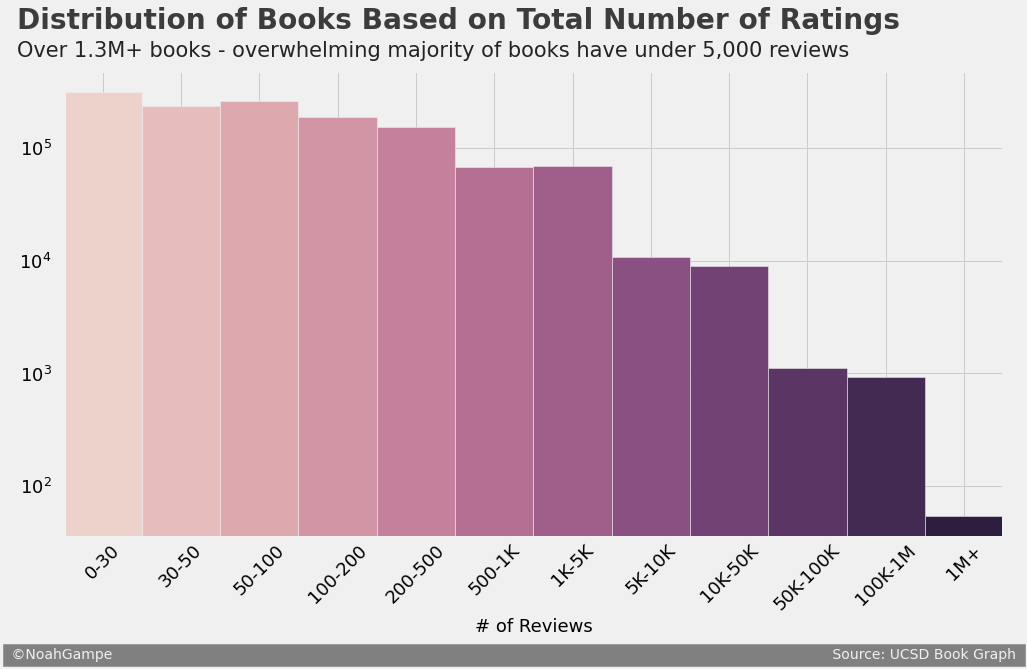

In [13]:
title = 'Distribution of Books Based on Total Number of Ratings'
sub = 'Over 1.3M+ books - overwhelming majority of books have under 5,000 reviews'
plot_dist_2(num_ratings_label, 'ratings_label', title, sub, 11)

# Creating A Search Engine

In order for us to create a useable search engine for our dataset, we'll be instantiating a TF-IDF Vectorizer. This will essentially create a matrix of TF-IDF values, which will allow us to find books that are similar to (if not exactly the same as) our queried book. We will be using the built-in scikit-learn [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) function to do the heavy computation for us. [This page](https://www.analyticsvidhya.com/blog/2021/11/how-sklearns-tfidfvectorizer-calculates-tf-idf-values/) gives a great explanation as to *how* scikit-learn calculates a TD-IDF matrix. Essentially, it will take every word in every title, and calculate how many times that word shows up in each book's title (including the original title). Then scikit-learn calculates how frequent or rare each word is in the entire dataset. Finally, it multiplies these two values together to give a number between 0 and 1. When we query for a book, it looks at these numbers to find relevant books (0 is not relevant and 1 is an exact match). This can obviously result in a *massive* matrix, which is why we cleaned up our titles earlier on.

In [14]:
#instantiate vectorizer to create TF matrix and calculate inverse document frequency
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(titles['mod_title'])

#function to return query results
def search(query, vectorizer):
    processed = re.sub('[^a-zA-Z0-9 ]', '', query.lower())
    query_vec = vectorizer.transform([processed])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -10)[-10:]
    results = (
        titles.iloc[indices]
        .sort_values('ratings', ascending=False)
    )
    return results.head(5).style.format({'url': make_clickable, 'cover_image': show_image})

#turns URL into clickable link
def make_clickable(val):
    return f'<a target="_blank" href="{val}">Goodreads</a>'

#shows image preview of book cover
def show_image(val):
    return f'<img src="{val}" width=50></img>'    

# Testing Our Search Engine

Now that we have a function that returns our query results, we can go ahead and build up a list of "liked" books by compiling various `book_id` values. We can go ahead and use this list of liked books later in our project as well.

In [15]:
#search for book, and add book_id to liked_books
search('The Rings of Saturn', vectorizer)

,book_id,title,author,ratings,avg. rating,url,cover_image,mod_title
1104962,434903,The Rings of Saturn,W.G. Sebald,5829,4.260000,Goodreads,,the rings of saturn
264364,25815,The Rings of Saturn,W.G. Sebald,320,4.260000,Goodreads,,the rings of saturn
723595,859890,The Rings of Saturn,W.G. Sebald,76,4.260000,Goodreads,,the rings of saturn
278561,29082615,The Rings of Saturn,W.G. Sebald,53,4.260000,Goodreads,,the rings of saturn
789424,1402760,"The Rings of Saturn (Time Machine, #6)",Arthur Byron Cover,49,3.780000,Goodreads,,the rings of saturn time machine 6


In [16]:
#list of book_ids to use in the recommendations notebook
liked_books = ['434903', '11047557', '29983711', '12073240', '11297',
               '12058235', '7117831', '11909375', '12073240', '102927',
               '12044809', '108218', '97411', '11617647', '975562',
               '1271159', '14', '1168191', '27209485', '4929', '1334340',
               '10799', '59950', '11275', '7718']

#manually rate the above books
book_ratings = [5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 4, 3, 4,
                3, 4, 5, 4, 5, 4, 3, 5, 4]

#function to grab columns of interest to us
def get_fields(bid):
    return {
        'user_id': -1, #-1 is me
        'book_id': titles[titles['book_id'] == bid].iloc[0,0],
        'rating': 0, #rate every book 0 for now
        'title': titles[titles['book_id'] == bid].iloc[0,1]
    }

#create dataframe of my liked books to convert to .csv
my_books = []
for i in liked_books:
    fields = get_fields(i)
    my_books.append(fields)
    
#convert to dataframe, change ratings, then create .csv
my_liked_books = pd.DataFrame.from_dict(my_books)
my_liked_books['rating'] = book_ratings
my_liked_books.to_csv('liked_books.csv', index=False)
my_liked_books.head()

,user_id,book_id,rating,title
0,-1,434903,5,The Rings of Saturn
1,-1,11047557,5,The Lord of the Rings
2,-1,29983711,5,Pachinko
3,-1,12073240,5,The Remains of the Day
4,-1,11297,5,Norwegian Wood


# Mapping IDs

The following code cell will allow us to map the correct `book_id` to the `csv_id` so that we can create a connection between our two data files (`goodreads_books.json.gz` & `goodreads_interactions.csv`)

In [17]:
#dict to hold book_id's 
csv_book_mapping = {}

#stream the .csv to add book_ids in csv_book_mapping dict
with open('book_id_map.csv', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        csv_id, book_id = line.strip().split(',')
        csv_book_mapping[csv_id] = book_id

# Find Users Similar To Us

Now we want to find users on goodreads who are similar to us. Additionally, we'd like to find the list of books that *they* like because, presumably, they'd have similar tastes as us. To begin, we'll create a set of users that have read *at least one* book from our list of liked books *and* gave that book a rating of 4+.

In [18]:
#set of users who have liked a book in our list and rated it 4 or higher
overlap_users = set()

#stream the .csv to get set of users who liked same books and gave it 4+ rating
#takes ~4 minutes
with open("goodreads_interactions.csv", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        user_id, csv_id, _, rating, _ = line.split(",")
        
        if user_id in overlap_users:
            continue

        try:
            rating = int(rating)
        except ValueError:
            continue
        
        book_id = csv_book_mapping[csv_id]
        
        if book_id in liked_books and rating >= 4:
            overlap_users.add(user_id)

Now that we have the list of users who have read at least one book from our list, we can create a list of the books *they* liked. Essentially, we will look to see if the `user_id` is in our `overlap_users` set. If it is, we go ahead and add the current book to our `rec_list` list. Note that the `goodreads_interactions.csv` file is roughly 4GB in size, so we don't want to be reading the entire thing into a pandas dataframe to save on resources.

In [19]:
#list of books from similar users
rec_lines = []

#takes ~2 minutes
with open("goodreads_interactions.csv", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        user_id, csv_id, _, rating, _ = line.split(",")
        
        if user_id in overlap_users:
            book_id = csv_book_mapping[csv_id]
            rec_lines.append([user_id, book_id, rating])

## Exploring Books From Similar Users

In [20]:
print(f"{'Books in dataset:':>34} {f'{len(csv_book_mapping)}':>8}")
print(f"{'Users w/ similar tastes:':>34} {f'{len(overlap_users)}':>8}")
print(f"{'Books rated >= 4 from those users:':>34} {f'{len(rec_lines)}':>8}")

#create dataframe of initial recommended books
recs = pd.DataFrame(rec_lines, columns=['user_id', 'book_id', 'rating'])
recs['book_id'] = recs['book_id'].astype(str)
recs.head()

                 Books in dataset:  2360651
          Users w/ similar tastes:    38747
Books rated >= 4 from those users: 18300553


,user_id,book_id,rating
0,17,21412673,0
1,17,13152194,0
2,17,8442457,0
3,17,2282,0
4,17,58345,3


In [21]:
#top 10 recommendations based on count
top_recs = recs['book_id'].value_counts().head(10)
top_recs = top_recs.index.values

#read in book titles to match with book_id
books_titles = pd.read_json('books_titles.json')
books_titles['book_id'] = books_titles['book_id'].astype(str)
books_titles.head() #verify

,book_id,title,author,ratings,avg. rating,url,cover_image,mod_title
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Barbara Hambly,140,4.03,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,the unschooled wizard sun wolf and starhawk 12
1,6066819,Best Friends Forever,Jennifer Weiner,51184,3.49,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,best friends forever
2,287141,The Aeneid for Boys and Girls,Alfred J. Church,46,4.13,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,the aeneid for boys and girls
3,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,Rachel Roberts,98,4.22,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,alls fairy in love and war avalon web of magic 8
4,287149,The Devil's Notebook,Anton Szandor LaVey,986,3.81,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,the devils notebook


In [22]:
#gets book titles whose id is in our top_recs
books_titles[books_titles['book_id'].isin(top_recs)]

,book_id,title,author,ratings,avg. rating,url,cover_image,mod_title
138759,11297,Norwegian Wood,Haruki Murakami,189394,4.02,https://www.goodreads.com/book/show/11297.Norw...,https://s.gr-assets.com/assets/nophoto/book/11...,norwegian wood
284473,2767052,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4899965,4.34,https://www.goodreads.com/book/show/2767052-th...,https://images.gr-assets.com/books/1447303603m...,the hunger games the hunger games 1
396828,7624,Lord of the Flies,William Golding,1638289,3.65,https://www.goodreads.com/book/show/7624.Lord_...,https://images.gr-assets.com/books/1327869409m...,lord of the flies
401395,5107,The Catcher in the Rye,J.D. Salinger,2086945,3.79,https://www.goodreads.com/book/show/5107.The_C...,https://images.gr-assets.com/books/1398034300m...,the catcher in the rye
463463,4671,The Great Gatsby,F. Scott Fitzgerald,2758812,3.89,https://www.goodreads.com/book/show/4671.The_G...,https://images.gr-assets.com/books/1490528560m...,the great gatsby
615314,5470,1984,George Orwell,2023937,4.14,https://www.goodreads.com/book/show/5470.1984,https://images.gr-assets.com/books/1348990566m...,1984
770177,7613,Animal Farm,George Orwell,1928931,3.88,https://www.goodreads.com/book/show/7613.Anima...,https://images.gr-assets.com/books/1424037542m...,animal farm
790927,2657,To Kill a Mockingbird,Harper Lee,3255518,4.26,https://www.goodreads.com/book/show/2657.To_Ki...,https://images.gr-assets.com/books/1361975680m...,to kill a mockingbird
851581,4929,Kafka on the Shore,Haruki Murakami,172711,4.13,https://www.goodreads.com/book/show/4929.Kafka...,https://s.gr-assets.com/assets/nophoto/book/11...,kafka on the shore
878545,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4765497,4.45,https://www.goodreads.com/book/show/3.Harry_Po...,https://images.gr-assets.com/books/1474154022m...,harry potter and the sorcerers stone harry pot...


As we can see from the above, we do in fact get some recommendations from similar users. However, a majority of the top 10 books are also *very* popular, and thus might not be as appealing to us individually. Ultimately, we'd like to have a system where we get recommendations that are a bit more personalized, and less generalized. We'll come back to improving this in a bit, but for now let's go back to our recommendations.

In [23]:
#create dataframe of all recommended books, based on book_count
all_recs = recs['book_id'].value_counts()
all_recs = all_recs.to_frame().reset_index()
all_recs.columns = ['book_id', 'book_count']
all_recs

,book_id,book_count
0,4671,22626
1,5470,21983
2,5107,21709
3,2657,21542
4,7613,18968
...,...,...
1192193,34313421,1
1192194,25249340,1
1192195,33393479,1
1192196,33106128,1


In [24]:
#combines all_recs with books_titles
all_recs = all_recs.merge(books_titles, how='inner', on='book_id')

#creates 'score' where books are penalized if they are popular in the general sense
#this helps find books that aren't insanely popular and recommended to everyone
all_recs['score'] = all_recs['book_count'] * (all_recs['book_count'] / all_recs['ratings'])
all_recs.sort_values('score', ascending=False).head(10)

,book_id,book_count,title,author,ratings,avg. rating,url,cover_image,mod_title,score
7,4929,17743,Kafka on the Shore,Haruki Murakami,172711,4.13,https://www.goodreads.com/book/show/4929.Kafka...,https://s.gr-assets.com/assets/nophoto/book/11...,kafka on the shore,1822.779377
5,11297,18377,Norwegian Wood,Haruki Murakami,189394,4.02,https://www.goodreads.com/book/show/11297.Norw...,https://s.gr-assets.com/assets/nophoto/book/11...,norwegian wood,1783.130031
19,11275,13913,The Wind-Up Bird Chronicle,Haruki Murakami,136559,4.17,https://www.goodreads.com/book/show/11275.The_...,https://images.gr-assets.com/books/1327872639m...,the windup bird chronicle,1417.494043
42,10357575,11589,1Q84,Haruki Murakami,129101,3.89,https://www.goodreads.com/book/show/10357575-1q84,https://images.gr-assets.com/books/1483103331m...,1q84,1040.308913
12557,9624993,187,"The Mirror and the Light (Thomas Cromwell, #3)",Hilary Mantel,40,4.08,https://www.goodreads.com/book/show/9624993-th...,https://s.gr-assets.com/assets/nophoto/book/11...,the mirror and the light thomas cromwell 3,874.225000
34,10799,12459,A Farewell to Arms,Ernest Hemingway,189957,3.79,https://www.goodreads.com/book/show/10799.A_Fa...,https://images.gr-assets.com/books/1313714836m...,a farewell to arms,817.167469
114,9557,7114,Sputnik Sweetheart,Haruki Murakami,63880,3.82,https://www.goodreads.com/book/show/9557.Sputn...,https://images.gr-assets.com/books/1508082438m...,sputnik sweetheart,792.251033
116,10374,7097,Hard-Boiled Wonderland and the End of the World,Haruki Murakami,65374,4.15,https://www.goodreads.com/book/show/10374.Hard...,https://images.gr-assets.com/books/1399844477m...,hardboiled wonderland and the end of the world,770.450164
128,17803,6803,After Dark,Haruki Murakami,65830,3.68,https://www.goodreads.com/book/show/17803.Afte...,https://s.gr-assets.com/assets/nophoto/book/11...,after dark,703.035227
8585,28170940,267,"Lethal White (Cormoran Strike, #4)",Robert Galbraith,106,4.00,https://www.goodreads.com/book/show/28170940-l...,https://s.gr-assets.com/assets/nophoto/book/11...,lethal white cormoran strike 4,672.537736


# Displaying Our Initial Recommendations

Though our recommendations aren't currently as good as they *can* be, they are still a decent first iteration. Let's re-use some functions from earlier to make our list of recommended books a bit more aesthetically pleasing!

In [25]:
#get list of books that were recommended over 200 times, and sort by score
popular_recs = all_recs[all_recs['book_count'] > 200].sort_values('score', ascending=False)

#remove books that we have already liked/read
popular_recs[~popular_recs['book_id'].isin(liked_books)].head(10).style.format({'url': make_clickable, 'cover_image': show_image})

,book_id,book_count,title,author,ratings,avg. rating,url,cover_image,mod_title,score
42,10357575,11589,1Q84,Haruki Murakami,129101,3.890000,Goodreads,,1q84,1040.308913
114,9557,7114,Sputnik Sweetheart,Haruki Murakami,63880,3.820000,Goodreads,,sputnik sweetheart,792.251033
116,10374,7097,Hard-Boiled Wonderland and the End of the World,Haruki Murakami,65374,4.150000,Goodreads,,hardboiled wonderland and the end of the world,770.450164
128,17803,6803,After Dark,Haruki Murakami,65830,3.680000,Goodreads,,after dark,703.035227
8585,28170940,267,"Lethal White (Cormoran Strike, #4)",Robert Galbraith,106,4.000000,Goodreads,,lethal white cormoran strike 4,672.537736
127,19288239,6807,Colorless Tsukuru Tazaki and His Years of Pilgrimage,Haruki Murakami,70556,3.820000,Goodreads,,colorless tsukuru tazaki and his years of pilgrimage,656.715928
215,17800,5127,"Dance Dance Dance (The Rat, #4)",Haruki Murakami,42021,4.030000,Goodreads,,dance dance dance the rat 4,625.547441
189,17799,5501,"South of the Border, West of the Sun",Haruki Murakami,48978,3.870000,Goodreads,,south of the border west of the sun,617.848851
164,11298,5891,"A Wild Sheep Chase (The Rat, #3)",Haruki Murakami,56601,3.940000,Goodreads,,a wild sheep chase the rat 3,613.131941
2393,11296,831,Haruki Murakami and the Music of Words,Jay Rubin,1265,3.800000,Goodreads,,haruki murakami and the music of words,545.898024


As we can see from the above, we are definitely getting some book recommendations. The problem however, is that 9 out of 10 of the recommended books are written by (or focused on) the same author - Haruki Murakami! While Murakami is definitely one of my favorite authors, I don't think I need to be recommended 9 of his books at once. We want more variety, since that will broaden our tastes and help us find new authors to enjoy. But how can we make that happen?

# Implementing Collaborative Filtering

As we just saw, our recommendation system is functional. But as with most things, it can always be better. We can incorporate [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to further improve our system. The big things we'll need to tackle are:

* Finding users with similar taste
    * Count the number of times a user has read a book in our list of liked books
* Filtering out users who have read below a certain threshold of our liked books
* Finding similar users rating
    * Get the list of books each similar user has rated
* Calculating a collaborative filtering matrix
    * Using built-in sklearn functions
* Generating new book recommendations
* Displaying new recommendations

In [26]:
#ensure no duplicates in our book list
book_set = set(my_liked_books['book_id'])

#frequency table of times a user read a book on our list
overlap_users_ft = {}

#takes ~2.5 minutes
with open("goodreads_interactions.csv", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        user_id, csv_id, _, rating, _ = line.split(",")
        
        book_id = csv_book_mapping.get(csv_id)
        
        if book_id in book_set:
            if user_id not in overlap_users_ft:
                overlap_users_ft[user_id] = 1
            else:
                overlap_users_ft[user_id] += 1

In [27]:
#filter users who have read 25% or more of the books in my_books
threshold = 0.25
filtered_overlap_users = set([k for k in overlap_users_ft if overlap_users_ft[k] > my_liked_books.shape[0]*threshold])

print(f'Users who read 1+ book on our list: {len(overlap_users_ft)}')
print(f'Users who read > 25% of books on our list: {len(filtered_overlap_users)}')

Users who read 1+ book on our list: 97461
Users who read > 25% of books on our list: 92


# Find Similar Users Book Lists

In [28]:
#get users book list
interactions_list = []

#takes about 1.5 minutes
with open("goodreads_interactions.csv", 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        user_id, csv_id, _, rating, _ = line.split(",")
        
        if user_id in filtered_overlap_users:
            book_id = csv_book_mapping[csv_id]
            interactions_list.append([user_id, book_id, rating])

# Create Collaborative Filtering Matrix

In [29]:
#create df with similar users book lists and add our book list to it
interactions = pd.DataFrame(interactions_list, columns=["user_id", "book_id", "rating"])
interactions = pd.concat([my_liked_books[["user_id", "book_id", "rating"]], interactions])
interactions

,user_id,book_id,rating
0,-1,434903,5
1,-1,11047557,5
2,-1,29983711,5
3,-1,12073240,5
4,-1,11297,5
...,...,...,...
1139179,437856,30091914,5
1139180,437856,23281518,4
1139181,437856,27430351,5
1139182,437856,33295190,0


In [30]:
#ensure columns are correct dtypes
interactions["book_id"] = interactions["book_id"].astype(str)
interactions["user_id"] = interactions["user_id"].astype(str)
interactions["rating"] = pd.to_numeric(interactions["rating"])

#gives sequential index for user and book id
interactions["user_index"] = interactions["user_id"].astype("category").cat.codes
interactions["book_index"] = interactions["book_id"].astype("category").cat.codes

#calculates coo_matrix
ratings_mat_coo = coo_matrix((interactions["rating"], (interactions["user_index"], interactions["book_index"])))
ratings_mat_coo.shape

(93, 421622)

# Exploring Similarities

In [31]:
ratings_mat = ratings_mat_coo.tocsr()
interactions[interactions["user_id"] == "-1"].head()

,user_id,book_id,rating,user_index,book_index
0,-1,434903,5,0,323091
1,-1,11047557,5,0,14591
2,-1,29983711,5,0,269638
3,-1,12073240,5,0,28964
4,-1,11297,5,0,18294


In [32]:
#get our index based on above
my_index = 0

#get similarities to other users (closer to 1 = more similar)
similarity = cosine_similarity(ratings_mat[my_index,:], ratings_mat).flatten()
similarity[0]

1.0000000000000002

In [33]:
#finds X indices of most similar users to us in terms of book tastes
find_similar_users = 30
indices = np.argpartition(similarity, -find_similar_users)[-find_similar_users:]
indices

array([28, 35, 82, 52, 67, 87, 19, 70, 21, 43, 73, 42, 75, 41,  2, 78, 85,
       29, 27, 53, 58, 80, 79, 72, 51, 39, 38, 22, 33,  0], dtype=int64)

In [34]:
#gets user id based on above indices
similar_users = interactions[interactions["user_index"].isin(indices)].copy()
similar_users = similar_users[similar_users["user_id"] != "-1"]
similar_users

,user_id,book_id,rating,user_index,book_index
13628,3199,939870,4,53,412000
13629,3199,15654,4,53,73077
13630,3199,5204,3,53,335171
13631,3199,17650,4,53,109826
13632,3199,42155,4,53,321172
...,...,...,...,...,...
1139179,437856,30091914,5,79,270741
1139180,437856,23281518,4,79,193283
1139181,437856,27430351,5,79,247153
1139182,437856,33295190,0,79,293965


# Getting Improved Book Recommendations

In [35]:
#how many time each book appeared in above recommendations
book_recs = similar_users.groupby("book_id").rating.agg(['count', 'mean'])
book_recs

,count,mean
book_id,,
1,16,3.937500
10000,7,0.714286
10000191,1,0.000000
1000059,1,4.000000
100006,1,0.000000
...,...,...
9998705,1,0.000000
999894,1,0.000000
999898,1,0.000000


In [36]:
#gets book title so that the above makes more sense
books_titles = pd.read_json("books_titles.json")
books_titles["book_id"] = books_titles["book_id"].astype(str)

#merge two datasets to get the titles into our recommendations
book_recs = book_recs.merge(books_titles, how="inner", on="book_id")
book_recs

,book_id,count,mean,title,author,ratings,avg. rating,url,cover_image,mod_title
0,1,16,3.937500,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,1713866,4.54,https://www.goodreads.com/book/show/1.Harry_Po...,https://images.gr-assets.com/books/1361039191m...,harry potter and the halfblood prince harry po...
1,10000,7,0.714286,The Face of Another,Kobo Abe,2079,3.78,https://www.goodreads.com/book/show/10000.The_...,https://images.gr-assets.com/books/1320415026m...,the face of another
2,10000191,1,0.000000,Yellow Crocus,Laila Ibrahim,17787,4.25,https://www.goodreads.com/book/show/10000191-y...,https://s.gr-assets.com/assets/nophoto/book/11...,yellow crocus
3,1000059,1,4.000000,"Green Arrow, Vol. 2: Sounds of Violence",Kevin Smith,1704,4.02,https://www.goodreads.com/book/show/1000059.Gr...,https://s.gr-assets.com/assets/nophoto/book/11...,green arrow vol 2 sounds of violence
4,100006,1,0.000000,Schrodinger's Kittens and the Search for Reali...,John Gribbin,1095,4.00,https://www.goodreads.com/book/show/100006.Sch...,https://images.gr-assets.com/books/1344269008m...,schrodingers kittens and the search for realit...
...,...,...,...,...,...,...,...,...,...,...
58516,9998705,1,0.000000,"Flash and Bones (Temperance Brennan, #14)",Kathy Reichs,14249,3.86,https://www.goodreads.com/book/show/9998705-fl...,https://images.gr-assets.com/books/1306253347m...,flash and bones temperance brennan 14
58517,999894,1,0.000000,"Bell, Book and Candle",John Van Druten,133,3.66,https://www.goodreads.com/book/show/999894.Bel...,https://s.gr-assets.com/assets/nophoto/book/11...,bell book and candle
58518,999898,1,0.000000,Twelve Pillars,Jim Rohn,901,4.38,https://www.goodreads.com/book/show/999898.Twe...,https://images.gr-assets.com/books/1360435414m...,twelve pillars
58519,9999,7,0.000000,The Box Man,Kobo Abe,2791,3.68,https://www.goodreads.com/book/show/9999.The_B...,https://images.gr-assets.com/books/1320459929m...,the box man


# Ranking Our Book Recommendations

In [37]:
#normalized count of times the book appeared for similar users relative to others
book_recs["adjusted_count"] = book_recs["count"] * (book_recs["count"] / book_recs["ratings"])
book_recs["score"] = book_recs["mean"] * book_recs["adjusted_count"]

#remove books we've already read based on id
book_recs = book_recs[~book_recs["book_id"].isin(my_liked_books["book_id"])]

#create mod_title (like in other notebook)
my_liked_books["mod_title"] = (
    my_liked_books["title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
    .str.lower()
    .str.replace("\s+", " ", regex=True)
)

#remove books we've already read based on mod_title
book_recs = book_recs[~book_recs["mod_title"].isin(my_liked_books["mod_title"])]

#remove books that appeared fewer than 2 times, whose mean rating > 4
book_recs = book_recs[book_recs["count"]>2]
book_recs = book_recs[book_recs["mean"] >=4]

#sort based on score
top_recs = book_recs.sort_values("score", ascending=False)
top_recs.head()

,book_id,count,mean,title,author,ratings,avg. rating,url,cover_image,mod_title,adjusted_count,score
47282,672172,3,4.000000,The Altar of the Dead,Henry James,237,3.53,https://www.goodreads.com/book/show/672172.The...,https://s.gr-assets.com/assets/nophoto/book/11...,the altar of the dead,0.037975,0.151899
39919,475080,3,4.333333,The Suppliants,Aeschylus,351,3.31,https://www.goodreads.com/book/show/475080.The...,https://s.gr-assets.com/assets/nophoto/book/11...,the suppliants,0.025641,0.111111
19023,19107,3,4.333333,"Diary of a Madman, The Government Inspector, ...",Nikolai Gogol,646,4.09,https://www.goodreads.com/book/show/19107.Diar...,https://s.gr-assets.com/assets/nophoto/book/11...,diary of a madman the government inspector sel...,0.013932,0.060372
56900,9484,3,5.000000,Within a Budding Grove (In Search of Lost Time...,Marcel Proust,813,4.40,https://www.goodreads.com/book/show/9484.Withi...,https://images.gr-assets.com/books/1320420357m...,within a budding grove in search of lost time 2,0.011070,0.055351
42553,556967,3,4.000000,Chamber Music,James Joyce,652,3.41,https://www.goodreads.com/book/show/556967.Cha...,https://images.gr-assets.com/books/1359729967m...,chamber music,0.013804,0.055215


# Displaying Our Improved Recommendations

In [38]:
top_recs.head(10).style.format({'url': make_clickable, 'cover_image': show_image})

,book_id,count,mean,title,author,ratings,avg. rating,url,cover_image,mod_title,adjusted_count,score
47282,672172,3,4.000000,The Altar of the Dead,Henry James,237,3.530000,Goodreads,,the altar of the dead,0.037975,0.151899
39919,475080,3,4.333333,The Suppliants,Aeschylus,351,3.310000,Goodreads,,the suppliants,0.025641,0.111111
19023,19107,3,4.333333,"Diary of a Madman, The Government Inspector, Selected Stories",Nikolai Gogol,646,4.090000,Goodreads,,diary of a madman the government inspector selected stories,0.013932,0.060372
56900,9484,3,5.000000,"Within a Budding Grove (In Search of Lost Time, #2)",Marcel Proust,813,4.400000,Goodreads,,within a budding grove in search of lost time 2,0.011070,0.055351
42553,556967,3,4.000000,Chamber Music,James Joyce,652,3.410000,Goodreads,,chamber music,0.013804,0.055215
21947,21976060,3,4.333333,The Art of Stillness: Adventures in Going Nowhere,Pico Iyer,2902,3.710000,Goodreads,,the art of stillness adventures in going nowhere,0.003101,0.013439
47544,6786692,3,4.000000,Battle Royale,Koushun Takami,2705,4.240000,Goodreads,,battle royale,0.003327,0.013309
7102,12951,3,4.000000,The Turn of the Screw and Other Short Fiction,Henry James,2929,3.800000,Goodreads,,the turn of the screw and other short fiction,0.003073,0.012291
29679,28348,4,4.500000,Crime and Punishment,Fyodor Dostoyevsky,6652,4.190000,Goodreads,,crime and punishment,0.002405,0.010824
52384,80458,3,4.666667,The Future of an Illusion,Sigmund Freud,3934,3.770000,Goodreads,,the future of an illusion,0.002288,0.010676


# Conclusions

We have clearly improved upon our initial recommendations through the implementation of collaborative filtering, as this time all 10 recommended books are written by a different author. I have actually never heard of a lot of these books either, so for me this is legitimately a great list of books to check out!

## Project Goals Review

* Become familiar with recommender systems - **DONE!**
* Parse .json data for data we're interested in - **DONE!**
* Build basic recommendation system - **DONE!**
* Improve recommendation system with collaborative filtering - **DONE!**
* Display results in an aesthetically pleasing manner - **DONE!**

# Further Steps

* Incorporate genre information
* Create item-based recommender system
* Add more visualizations